In [1]:
pip install optuna scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 

In [2]:
!wget https://raw.githubusercontent.com/serivan/DeepLearning/master/Optuna/optuna.log
!wget https://raw.githubusercontent.com/serivan/DeepLearning/master/Optuna/dataset/adult.csv
!wget https://raw.githubusercontent.com/serivan/DeepLearning/master/Optuna/adult.txt
#!wget https://github.com/serivan/DeepLearning/raw/master/Optuna/weights/adult/init_weights_214.index
#!wget "https://github.com/serivan/DeepLearning/raw/master/Optuna/weights/adult/init_weights_214.data-00000-of-00001"

--2024-05-05 15:23:18--  https://raw.githubusercontent.com/serivan/DeepLearning/master/Optuna/optuna.log
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8099768 (7.7M) [text/plain]
Saving to: ‘optuna.log’

optuna.log          100%[===================>]   7.72M  --.-KB/s    in 0.03s   

2024-05-05 15:23:18 (261 MB/s) - ‘optuna.log’ saved [8099768/8099768]

--2024-05-05 15:23:18--  https://raw.githubusercontent.com/serivan/DeepLearning/master/Optuna/dataset/adult.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1810442 (1.7M) [te

In [3]:
import tensorflow as tf
import random
import numpy as np
import math
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import (
    fbeta_score,
    accuracy_score,
)
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted, check_X_y
from sklearn.calibration import CalibratedClassifierCV


In [4]:
RANDOM_STATE = 3993
TEST_SIZE = 0.3
INTER_OPS = 0  # Independent non-blocking operations.
INTRA_OPS = 0  # Internal Matrix multiplication and reductions.

tf.config.threading.set_inter_op_parallelism_threads(INTER_OPS)
tf.config.threading.set_intra_op_parallelism_threads(INTRA_OPS)
tf.device('/cpu:0')

np.random.seed(seed=RANDOM_STATE)
tf.random.set_seed(seed=RANDOM_STATE)
random.seed(RANDOM_STATE)

In [5]:
DATASET = "adult"

dataset_path = "./adult.csv"
df = pd.read_csv(dataset_path)
NUM_CLASSES = np.unique(df['class']).size
scale = sklearn.preprocessing.StandardScaler()

X, y = df.drop(columns='class').values, df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [6]:
def create_model(trial):
    n_hidden = trial.suggest_int('n_hidden', 1, 5)
    hidden_units = trial.suggest_int('hidden_units', 32, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0, 0.6)
    hidden_activation = trial.suggest_categorical("hidden_activation", ["relu", "sigmoid", "tanh"])
    batch_norm = trial.suggest_categorical("batch_norm", ["True", "False"])
    activity_regularizer = trial.suggest_categorical("activity_regularizer", ["True", "False"])

    kernel_initializer = {
        "relu": "he_uniform",
        "selu": "lecun_normal",
        "elu": "he_uniform",
        "swish": "he_uniform",
    }.get(hidden_activation, "glorot_uniform")


    model = Sequential()

    model.add(
        Input(
            shape=X_train.shape[1:],
        )
    )

    for i in range(n_hidden):
        model.add(
            Dense(
                units=hidden_units,
                activation=hidden_activation,
                activity_regularizer=tf.keras.regularizers.L2(1e-5) if activity_regularizer else None,
                kernel_initializer=kernel_initializer,
            )
        )
        model.add(
            Dropout(dropout)
        )

        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())

        hidden_units = int(hidden_units / 2)


    if NUM_CLASSES > 2:
        model.add(
            Dense(
                NUM_CLASSES,
                activation="softmax"
            )
        )

        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics='accuracy',
        )
    else:
        model.add(
            Dense(
                1,
                activation="sigmoid"
            )
        )

        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics='accuracy',
        )

    return model

In [7]:
def multi_stratified_kfold(X_train, y_train):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

    folds = list()
    for train_index, val_index in skf.split(X_train, y_train):
        # Get labels
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        # Append folds
        folds.append(
            (
                X_train[train_index],
                X_train[val_index],
                y_train_fold,
                y_val_fold,
            ),
        )

    return folds

In [8]:
def objective(trial):
    init_weights_pathname = "./init_weights_" + str(trial.number)

    trial.set_user_attr("init_weights_pathname", init_weights_pathname)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="min", restore_best_weights=False)

    model = create_model(trial)

    #model.save_weights(init_weights_pathname)

    batch_size = trial.suggest_categorical("batch_size", [32, 40, 48, 56, 64])

    folds_results = defaultdict(list)

    for i, fold_split in enumerate(mskfolds):

        trial.set_user_attr("fold", i+1)

        X_train_fold, X_val_fold, y_train_fold, y_val_fold = fold_split

        model.load_weights(init_weights_pathname)

        trial.set_user_attr("fit", "in corso")

        history = model.fit(
            x=X_train_fold,
            y=y_train_fold,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=50,
            callbacks=[callback],
            verbose=0,
        )

        trial.set_user_attr("fit", "terminato")


        loss_fold, accuracy_fold = model.evaluate(
            X_val_fold, y_val_fold, verbose=0
        )


        folds_results["fold"].append(i)
        folds_results["test_loss"].append(loss_fold)
        folds_results["test_accuracy"].append(accuracy_fold)


        for k, v in history.history.items():
            folds_results[k].append(v[-1])

        min_num_folds = 2

        if i >= min_num_folds:
            intermediate_score = np.mean(folds_results["test_accuracy"])
            trial.report(intermediate_score, i - min_num_folds)
            if trial.should_prune():
                raise optuna.TrialPruned()

    result = np.mean(folds_results["test_accuracy"])

    return result

In [9]:
study_name = DATASET + "-study"
study_path = "./optuna.log"
storage_name = JournalStorage(JournalFileStorage(study_path))
mskfolds = multi_stratified_kfold(X_train, y_train)
study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.DEBUG)

<ipython-input-9-aeefad31ade7>:3: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage_name = JournalStorage(JournalFileStorage(study_path))
[I 2024-05-05 15:23:31,240] Using an existing study with name 'adult-study' instead of creating a new one.


In [10]:
def delete_init_model_weights_callback(
    study: optuna.Study, trial: optuna.trial.FrozenTrial
):
    """Callback that removes initial weights of unoptimal models"""
    if study.best_trial.number != trial.number:
        os.remove(trial.user_attrs["init_weights_pathname"])

In [11]:
'''
study.optimize(
    objective,
    n_trials=256,
    n_jobs=-1,
    gc_after_trial=True,
    #callbacks=[delete_init_model_weights_callback],
)
'''

'\nstudy.optimize(\n    objective,\n    n_trials=256,\n    n_jobs=-1,\n    gc_after_trial=True,\n    #callbacks=[delete_init_model_weights_callback],\n)\n'

In [12]:
print(study.best_trial.number)
print(study.best_params)
print(study.best_value)
f = open("/" + DATASET + ".txt", "w")
f.write(str(study.best_params) + "\n")
f.write(str(study.best_value))
f.close()

214
{'n_hidden': 2, 'hidden_units': 211, 'learning_rate': 0.0008119015815876429, 'dropout': 0.025054480961881016, 'hidden_activation': 'sigmoid', 'batch_norm': 'True', 'activity_regularizer': 'True', 'batch_size': 48}
0.8519700229167938


<ipython-input-13-471f79a759ba>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

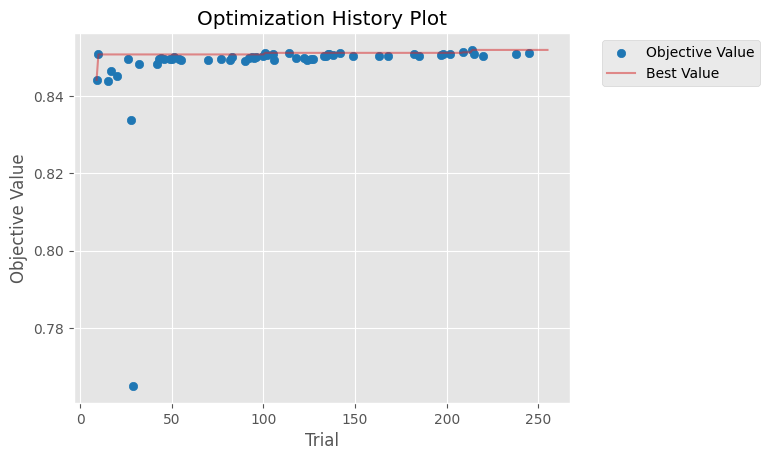

In [13]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<ipython-input-14-ac243543a9b5>:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<Axes: xlabel='activity_regularizer', ylabel='Objective Value'>,
       <Axes: xlabel='batch_norm'>, <Axes: xlabel='batch_size'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='hidden_activation'>,
       <Axes: xlabel='hidden_units'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='n_hidden'>], dtype=object)

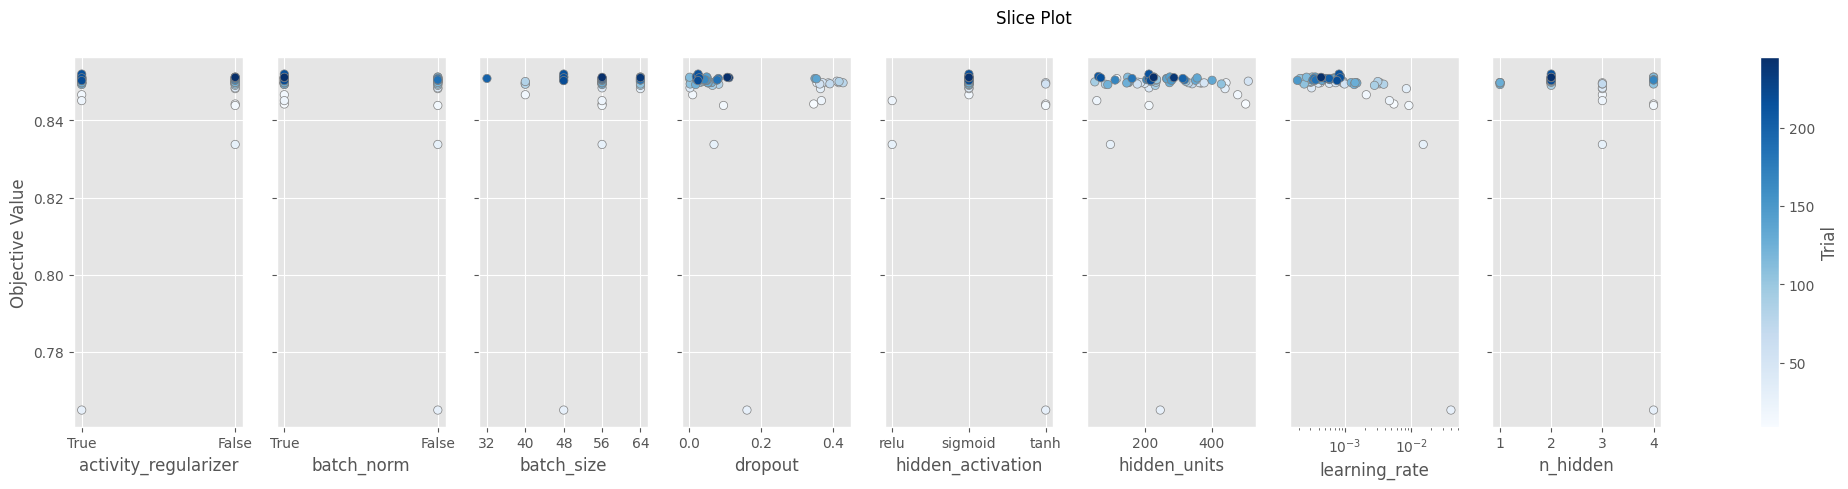

In [14]:
optuna.visualization.matplotlib.plot_slice(study)

<ipython-input-15-a5c7740d20da>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

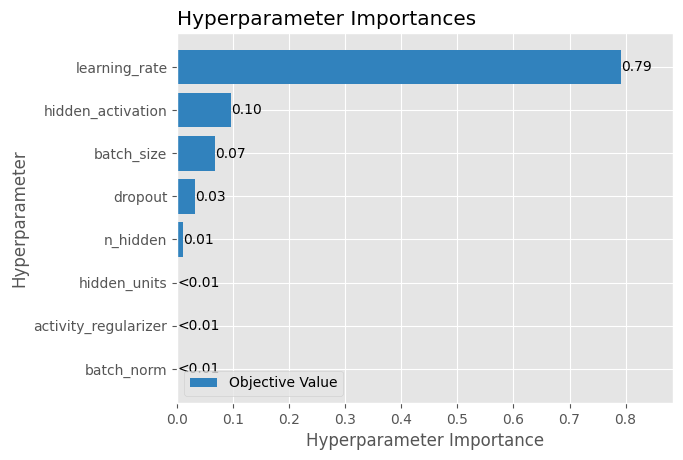

In [15]:
optuna.visualization.matplotlib.plot_param_importances(study)

Allenamento della rete neurale

In [16]:
def create_final_model():

    n_hidden = best_params["n_hidden"]
    hidden_units = best_params["hidden_units"]
    learning_rate = best_params["learning_rate"]
    dropout = best_params["dropout"]
    hidden_activation = best_params["hidden_activation"]
    batch_norm = best_params["batch_norm"]
    activity_regularizer = best_params["activity_regularizer"]

    kernel_initializer = {
        "relu": "he_uniform",
        "selu": "lecun_normal",
        "elu": "he_uniform",
        "swish": "he_uniform",
    }.get(hidden_activation, "glorot_uniform")


    model = Sequential()

    model.add(
        Input(
            shape=X_train.shape[1:],
        )
    )

    for i in range(n_hidden):
        model.add(
            Dense(
                units=hidden_units,
                activation=hidden_activation,
                activity_regularizer=tf.keras.regularizers.L2(1e-5) if activity_regularizer else None,
                kernel_initializer=kernel_initializer,
            )
        )
        model.add(
            Dropout(dropout)
        )

        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())

        hidden_units = int(hidden_units / 2)


    if NUM_CLASSES > 2:
        model.add(
            Dense(
                NUM_CLASSES,
                activation="softmax"
            )
        )

        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics='accuracy',
        )
    else:
        model.add(
            Dense(
                1,
                activation="sigmoid"
            )
        )

        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy'],
        )

    #model.load_weights(init_weights_pathname)

    return model

In [17]:
storage_name = JournalStorage(JournalFileStorage("./optuna.log"))
study_name = DATASET + "-study"
study = optuna.load_study(storage=storage_name, study_name=study_name)
best_params = study.best_params
batch_size = best_params.pop("batch_size")
#init_weights_pathname = "./init_weights_" + str(study.best_trial.number)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min", restore_best_weights=True)

<ipython-input-17-25c9e0964efc>:1: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage_name = JournalStorage(JournalFileStorage("./optuna.log"))


In [18]:
base_estimator = KerasClassifier(model=create_final_model, epochs=10, batch_size=batch_size, validation_split=0.2, callbacks=[callback], verbose=1)
print(base_estimator.model().summary())
base_estimator.fit(
    X_train,
    y_train,
    verbose=1
)
prediction_base = base_estimator.predict(X_test, verbose=0)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 211)                 │           2,954 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 211)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 211)                 │             844 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 105)                 │          22,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 105)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 105)                 │             420 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             106 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,584 (103.84 KB)

 Trainable params: 25,952 (101.38 KB)

 Non-trainable params: 632 (2.47 KB)

None
Epoch 1/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7591 - loss: 0.5392 - val_accuracy: 0.8343 - val_loss: 0.3926
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8344 - loss: 0.3929 - val_accuracy: 0.8406 - val_loss: 0.3715
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8403 - loss: 0.3755 - val_accuracy: 0.8409 - val_loss: 0.3647
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8432 - loss: 0.3635 - val_accuracy: 0.8412 - val_loss: 0.3581
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8463 - loss: 0.3554 - val_accuracy: 0.8425 - val_loss: 0.3537
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8459 - loss: 0.3481 - val_accuracy: 0.8440 - val_loss: 0.3484
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8474 - loss: 0.3439 - val_accuracy: 0.8437 - val_loss: 0.3441
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8504 - loss: 0.3393 - val_accur

In [19]:
print("Score Train: " + str(base_estimator.score(X_train, y_train)))
print("Score Test: " + str(base_estimator.score(X_test, y_test)))

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Score Train: 0.8521746760654012
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Score Test: 0.850815532655429
